Having figured out an initial implementation, run a few trials to figure out the intrinsic dimension of MNIST. According to the paper, at intrinsic dimension of 10, the paper manages to recover near 100% of the baseline network performance.

In [1]:
from net import SubspaceLinear

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data

In [4]:
dataset_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Lambda(lambda x: torch.flatten(x))
])

In [5]:
train = torchvision.datasets.MNIST(
    root="~/.torchdata/", download=False, 
    # natively stored as PIL images
    transform=dataset_transform
)

In [6]:
test = torchvision.datasets.MNIST(
    root="~/.torchdata/", download=False, 
    train=False,
    transform=dataset_transform
)

In [7]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)
# Returns (torch.Size([100, 784]), torch.Size([100]))
test_loader = DataLoader(test, batch_size=500, shuffle=False)

## Baseline network

In [8]:
class BasicMNIST(nn.Module):
    def __init__(self):
        """
        Paper uses 784-200-200-10
        ref: https://arxiv.org/pdf/1804.08838.pdf
        
        Ref in github:
        https://github.com/uber-research/intrinsic-dimension/blob/9754ebe1954e82973c7afe280d2c59850f281dca/intrinsic_dim/model_builders.py#L81
        """
        super().__init__()
        self.hidden1 = nn.Linear(784, 200)
        self.hidden2 = nn.Linear(200, 10)
        
    def forward(self, x):
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = F.log_softmax(x, dim=-1)  # (batch_size, dims)
        return x

In [9]:
def train(net, num_epochs, train_loader):
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)
    net.train()
    loss_history = []
    acc_history = []
    
    for _ in range(num_epochs):
        for batch_id, (features, target) in enumerate(train_loader):
            # forward pass, calculate loss and backprop!
            opt.zero_grad()
            preds = net(features)
            loss = F.nll_loss(preds, target)
            loss.backward()
            loss_history.append(loss.item())
            opt.step()

            if batch_id % 100 == 0:
                print(loss.item())
                
    # Verified don't need to return the net
    return loss_history, acc_history

In [10]:
def eval(net, test_loader):
    net.eval()
    test_loss = 0
    correct = 0

    for features, target in test_loader:
        output = net(features)
        test_loss += F.nll_loss(output, target).item()
        pred = torch.argmax(output, dim=-1) # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    accuracy = 100. * correct / len(test_loader.dataset)
    acc_history.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    
    return test_loss, correct.item()

## Nets with subspace training

In [11]:
class SubspaceConstrainedMNIST(nn.Module):
    def __init__(self, subspace_features: int):
        """
        Paper uses 784-200-200-10
        ref: https://arxiv.org/pdf/1804.08838.pdf
        
        Ref in github:
        https://github.com/uber-research/intrinsic-dimension/blob/9754ebe1954e82973c7afe280d2c59850f281dca/intrinsic_dim/model_builders.py#L81
        """
        super().__init__()
        self.hidden1 = SubspaceLinear(784, 200, subspace_features=subspace_features)
        self.hidden2 = SubspaceLinear(200, 10, subspace_features=subspace_features)
        
    def forward(self, x):
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = F.log_softmax(x, dim=-1)  # (batch_size, dims)
        return x

In [12]:
loss_histories = {}
acc_histories = {}
test_losses = {}
corrects = {}

In [13]:
loss_histories_per_dim = {}
acc_histories_per_dim = {}
test_losses_per_dim = {}
corrects_per_dim = {}

for i in range(10):
    net = BasicMNIST()
    loss_history, acc_history = train(net, 15, train_loader)
    test_loss, correct = eval(net, test_loader)
    
    # Store everything
    loss_histories_per_dim[i] = loss_history
    acc_histories_per_dim[i] = acc_history
    test_losses_per_dim[i] = test_loss
    corrects_per_dim[i] = correct
    
loss_histories["baseline"] = loss_histories_per_dim
acc_histories["baseline"] = acc_histories_per_dim
test_losses["baseline"] = test_losses_per_dim
corrects["baseline"] = corrects_per_dim

2.2936007976531982
1.0616132020950317
0.6721163392066956
0.5253994464874268
0.7128549814224243
0.7386283278465271
0.5276216864585876
0.7749720811843872
0.504633903503418
0.716871440410614
0.446662038564682
0.5543412566184998
0.7547324299812317
0.4091881215572357
0.5887427926063538
0.5838301181793213
0.4638390839099884
0.837116003036499
0.6309587359428406
0.6372181177139282
0.5915499329566956
0.3977026045322418
0.4929933547973633
0.48084795475006104
0.5416667461395264
0.48464930057525635
0.4404582977294922
0.4838465452194214
0.3938785493373871
0.5134761333465576
0.4892166554927826
0.4788067936897278
0.4314503073692322
0.3897969424724579
0.604373037815094
0.4990023672580719
0.7816734910011292
0.5804060697555542
0.35984647274017334
0.5518972277641296
0.5253532528877258
0.5957705974578857
0.44459521770477295
0.5586245059967041
0.5407680869102478
0.6431199908256531
0.6072264313697815
0.34658491611480713
0.5053234696388245
0.5586241483688354
0.4173366129398346
0.581774115562439
0.53178358078

In [14]:
for d in range(1, 11):
    loss_histories_per_dim = {}
    acc_histories_per_dim = {}
    test_losses_per_dim = {}
    corrects_per_dim = {}
    for i in range(10):
        ssnet = SubspaceConstrainedMNIST(subspace_features=d)
        loss_history, acc_history = train(ssnet, 15, train_loader)
        test_loss, correct = eval(ssnet, test_loader)

        # Store everything
        loss_histories_per_dim[i] = loss_history
        acc_histories_per_dim[i] = acc_history
        test_losses_per_dim[i] = test_loss
        corrects_per_dim[i] = correct / 10000 * 100
        
    loss_histories[d] = loss_histories_per_dim
    acc_histories[d] = acc_histories_per_dim
    test_losses[d] = test_losses_per_dim
    corrects[d] = corrects_per_dim

2.315112829208374
2.093477249145508
2.0984888076782227
1.9050554037094116
1.8560986518859863
1.9437068700790405
1.9845893383026123
1.654474139213562
1.734060525894165
1.710499882698059
1.7248033285140991
1.5001029968261719
1.727288842201233
1.6320980787277222
1.6928635835647583
1.5769734382629395
1.7100486755371094
1.6785556077957153
1.6890324354171753
1.451074242591858
1.5855185985565186
1.4999303817749023
1.4495846033096313
1.4844253063201904
1.478034496307373
1.3612353801727295
1.5331422090530396
1.5579333305358887
1.469553828239441
1.454526662826538
1.6547274589538574
1.5663403272628784
1.5675572156906128
1.5480220317840576
1.5966335535049438
1.3890897035598755
1.5651123523712158
1.5733354091644287
1.4605116844177246
1.580375075340271
1.346972942352295
1.379367709159851
1.379673957824707
1.513370394706726
1.5346095561981201
1.4703538417816162
1.413506269454956
1.3950752019882202
1.5208020210266113
1.271967887878418
1.5604147911071777
1.573796272277832
1.5510525703430176
1.338413238

In [15]:
dim_scores = pd.DataFrame.from_dict(corrects)

In [16]:
dim_scores.columns = [str(i) for i in dim_scores.columns]

In [17]:
dim_scores

,baseline,1,2,3,4,5,6,7,8,9,10
0,7905,53.76,75.92,85.00,88.25,90.95,92.80,67.39,94.03,95.01,95.56
1,9781,55.58,72.63,81.45,88.28,90.92,92.40,93.88,85.52,85.92,95.40
2,7890,48.09,73.37,83.86,87.29,91.11,92.79,93.87,94.45,95.08,94.99
3,8880,53.40,73.59,83.32,88.51,83.96,91.75,93.84,94.95,95.09,95.32
4,9795,55.86,71.65,81.29,88.37,91.22,92.86,93.59,94.73,94.80,95.35
5,8837,54.81,77.37,84.07,88.58,91.86,92.80,94.10,94.56,95.17,95.25
6,7715,56.12,69.68,66.53,87.19,91.05,92.36,93.54,94.80,95.09,95.22
7,8873,57.63,68.25,84.01,88.66,91.49,92.28,93.97,94.57,95.06,95.22
8,7684,60.69,75.94,73.41,88.63,90.08,92.75,93.82,94.35,94.83,95.47
9,9771,57.18,72.84,83.31,77.77,91.30,92.68,93.74,94.29,95.16,95.45


In [18]:
dim_scores.to_csv("mnist-scores.csv")

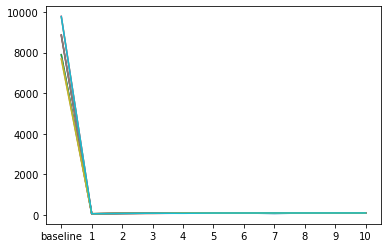

In [19]:
plt.plot(dim_scores.T)

In [20]:
for i, j in ssnet.named_parameters():
    print(i, j.shape)

hidden1.bias torch.Size([200])
hidden1.theta_prime torch.Size([10, 784])
hidden2.bias torch.Size([10])
hidden2.theta_prime torch.Size([10, 200])


In [21]:
# sns.boxplot(dim_scores.T)  # needs to be in the right format

Further reading led me to realize the model only has a single Theta prime. Thus each layer needs to refer to the same theta prime!